In [7]:
import os
import tensorflow as tf
from tensorflow.keras.layers import Layer
import numpy as np
import sionna as sn
from sionna.phy.utils import complex_normal
from sionna.phy.signal import fft, ifft
from tensorflow.python.ops.numpy_ops import np_config
# np_config.enable_numpy_behavior()
import matplotlib.pyplot as plt
# import tensorflow_probability as tfp
import math as m
pi = tf.constant(m.pi)

In [8]:
def nextpow2(N):
    """ Function for finding the next power of 2 """
    n = 1
    while n < N: n *= 2
    return n

### Phase noise function in Dileepa's paper

In [9]:
class PhaseNoise(Layer):
    def __init__(self, model_type='10', bandwidth=7e9, fc=140e9, n_samples=1024, **kwargs):
        super().__init__()
        self._real_dtype = tf.dtypes.as_dtype(self.dtype).real_dtype
        self.model_type = model_type
        self.bandwidth = bandwidth
        self.fc = fc
        self.n_samples = n_samples

        samples = 2 * nextpow2(n_samples)
        self.samples = samples  # upper limit

        fvec = (self.bandwidth / 2) * np.linspace(0, 1, self.samples)

        # 3GPP TR38.803 v14.2.0 70GHz PLL phase noise model Table 6.1.10.1-3
        if self.model_type == '10':

            fref = 70e9  # 70 GHz reference
            psd0 = 8894  # 39.49 dB
            fz = [3e3, 396e3, 754e6]
            az = [2.37, 2.7, 2.53]
            fp = [1, 1.55e6, 30e6]
            ap = [3.3, 3.3, 1]

            lf = psd0 * np.ones([1, self.samples])  # PN PSD
            for n in range(3):
                lf = lf * (1 + np.power((fvec / fz[n]), az[n])) / (1 + np.power((fvec / fp[n]), ap[n]))
            # scale to carrier frq
            lf = lf * np.square((self.fc / fref))

        # 3GPP TR38.803 v14.2.0 UE model 1 Table 6.1.11.2-1
        if self.model_type == '11':
            # loop bandwidth
            LBW = 187e3  # Hz

            # all vectors contain values for and in order of
            # REF clk  PLL  VCO 1/f^2  VCO 1/f^3
            # Figure Of Merit
            FOM = [-215, -240, -175, -130]
            # zero-point frequency
            fz = [float('inf'), 1e4, 50.3e6, float('inf')]
            # Power consumption (mW)
            P = [10, 20, 20, 20]
            # zero-point power
            k = [2, 1, 2, 3]

            f_low = np.take(fvec, np.where(fvec <= LBW))
            f_high = np.take(fvec, np.where(fvec > LBW))

            PSD0 = FOM + 20 * np.log10(self.fc) - 10 * np.log10(
                P)  # x dB, actually P/1mW

            fn = lambda f, psd0, fz, k: np.power(10.0, psd0 / 10.0) * (
                    (1.0 + np.power((f / fz), k)) / (1.0 + np.power(f, k)))

            lf = np.concatenate([fn(f_low, PSD0[0], fz[0], k[0]) + fn(f_low, PSD0[1], fz[1], k[1]),
                                 fn(f_high, PSD0[2], fz[2], k[2]) + fn(f_high, PSD0[3], fz[3], k[3])], axis=1)
            # plot_PSD = True
            # if (plot_PSD):
            #
            #     fig = plt.figure()
            #
            #     # Subplots
            #     ax2 = fig.add_subplot(221)
            #     ax2.semilogx(fvec, tf.squeeze(10 * np.log10(fn(fvec, PSD0[0], fz[0], k[0]))))
            #     ax2.set_ylabel('Phase noise PSD [dBc/Hz]')
            #     ax2.set_xlabel('Frequency offset [Hz]')
            #     ax2.set_xlim([1e2, 1e10])
            #     ax2.set_title('REF')
            #     ax2.grid(True)
            #
            #     ax3 = fig.add_subplot(222)
            #     ax3.semilogx(fvec, tf.squeeze(10 * np.log10(fn(fvec, PSD0[1], fz[1], k[1]))))
            #     ax3.set_ylabel('Phase noise PSD [dBc/Hz]')
            #     ax3.set_xlabel('Frequency offset [Hz]')
            #     ax3.set_xlim([1e2, 1e10])
            #     ax3.set_title('PLL')
            #     ax3.grid(True)
            #
            #     ax4 = fig.add_subplot(223)
            #     ax4.semilogx(fvec, tf.squeeze(10 * np.log10(fn(fvec, PSD0[2], fz[2], k[2]))))
            #     ax4.set_ylabel('Phase noise PSD [dBc/Hz]')
            #     ax4.set_xlabel('Frequency offset [Hz]')
            #     ax4.set_xlim([1e2, 1e10])
            #     ax4.set_title('1/f^2')
            #     ax4.grid(True)
            #
            #     ax5 = fig.add_subplot(224)
            #     ax5.semilogx(fvec, tf.squeeze(10 * np.log10(fn(fvec, PSD0[3], fz[3], k[3]))))
            #     ax5.set_ylabel('Phase noise PSD [dBc/Hz]')
            #     ax5.set_xlabel('Frequency offset [Hz]')
            #     ax5.set_xlim([1e2, 1e10])
            #     ax5.set_title('1/f^3')
            #     ax5.grid(True)
            #
            #     plt.tight_layout()  # Adjust layout for subplots
            #     plt.show()

        # 3GPP TR38.803 v14.2.0 BS model 2
        if self.model_type == '12':
            # loop bandwidth
            LBW = 112e3  # Hz

            # all vectors contain values for and in order of
            # REF clk  PLL  VCO 1/f^2  VCO 1/f^3
            # Figure Of Merit
            FOM = [-240, -245, -187, -130]
            # zero-point frequency
            fz = [float('inf'), 1e4, 8e6, float('inf')]
            # Power consumption (mW)
            P = [10, 20, 50, 50]
            # zero-point power
            k = [2, 1, 2, 3]

            f_low = np.take(fvec, np.where(fvec <= LBW))
            f_high = np.take(fvec, np.where(fvec > LBW))

            PSD0 = FOM + 20 * np.log10(self.fc) - 10 * np.log10(P)  # x dB, actually P/1mW

            fn = lambda f, psd0, fz, k: np.power(10.0, psd0 / 10.0) * (
                    (1.0 + np.power((f / fz), k)) / (1.0 + np.power(f, k)))

            lf = np.concatenate([fn(f_low, PSD0[0], fz[0], k[0]) + fn(f_low, PSD0[1], fz[1], k[1]),
                                 fn(f_high, PSD0[2], fz[2], k[2]) + fn(f_high, PSD0[3], fz[3], k[3])], axis=1)

            # if (plot_PSD):
            #
            #     fig = plt.figure()
            #
            #     # Subplots
            #     ax2 = fig.add_subplot(221)
            #     ax2.semilogx(fvec_ex, tf.squeeze(10 * np.log10(fn(fvec_ex, PSD0[0], fz[0], k[0]))))
            #     ax2.set_ylabel('Phase noise PSD [dBc/Hz]')
            #     ax2.set_xlabel('Frequency offset [Hz]')
            #     ax2.set_xlim([1e2, 1e10])
            #     ax2.set_title('REF')
            #     ax2.grid(True)
            #
            #     ax3 = fig.add_subplot(222)
            #     ax3.semilogx(fvec_ex, tf.squeeze(10 * np.log10(fn(fvec_ex, PSD0[1], fz[1], k[1]))))
            #     ax3.set_ylabel('Phase noise PSD [dBc/Hz]')
            #     ax3.set_xlabel('Frequency offset [Hz]')
            #     ax3.set_xlim([1e2, 1e10])
            #     ax3.set_title('PLL')
            #     ax3.grid(True)
            #
            #     ax4 = fig.add_subplot(223)
            #     ax4.semilogx(fvec_ex, tf.squeeze(10 * np.log10(fn(fvec_ex, PSD0[2], fz[2], k[2]))))
            #     ax4.set_ylabel('Phase noise PSD [dBc/Hz]')
            #     ax4.set_xlabel('Frequency offset [Hz]')
            #     ax4.set_xlim([1e2, 1e10])
            #     ax4.set_title('1/f^2')
            #     ax4.grid(True)
            #
            #     ax5 = fig.add_subplot(224)
            #     ax5.semilogx(fvec_ex, tf.squeeze(10 * np.log10(fn(fvec_ex, PSD0[3], fz[3], k[3]))))
            #     ax5.set_ylabel('Phase noise PSD [dBc/Hz]')
            #     ax5.set_xlabel('Frequency offset [Hz]')
            #     ax5.set_xlim([1e2, 1e10])
            #     ax5.set_title('1/f^3')
            #     ax5.grid(True)
            #
            #     plt.tight_layout()  # Adjust layout for subplots
            #     plt.show()

        if self.model_type == '13':
            # Texas Instruments LMX2595 at 20GHz carrier freq
            # Fig 14 of data sheet revised April 2019

            # measured PN PSD is approximated by polynomials
            # (similar to 3GPP case 10 with n,m = 1,2)
            # f_meas = [1e2 1e3 1e4 1e5 1e6 10e6 40e6 95e6 100e6 fp(end)];
            # psd_meas = [-82.8 -92.2 -100.9 -104.1 -116.5 -140.5 -147.2 -147.7 -147.7 -147.7];

            fref = 20e9  # 70 GHz reference
            psd0 = 10 ** ((-72.0) / 10)  # 39.49 dB
            fz = [3e4, 1.75e7]
            az = [1.4, 2.55]
            fp = [1e1, 3e5]
            ap = [1, 2.95]

            lf = psd0 * np.ones([1, self.samples])  # PN PSD
            for n in range(2):
                lf = lf * (1 + np.power((fvec / fz[n]), az[n])) / (1 + np.power((fvec / fp[n]), ap[n]))
            # scale to carrier frq
            lf = lf * np.square((self.fc / fref))
        # NEU 130 Ghz
        if self.model_type == '16':

            fref = 130e9  # 70 GHz reference
            psd0 = 10 ** ((-66.5) / 10)  # 39.49 dB
            fz = [0.01e6, 6.0e6, 10.0e6]
            az = [2.0,2.0,2.0]
            fp = [0.005e6,0.03e6,5.0e6]
            ap = [2.0,2.0,2.0]

            lf = psd0 * np.ones([1, self.samples])  # PN PSD
            for n in range(3):
                lf = lf * (1 + np.power((fvec / fz[n]), az[n])) / (1 + np.power((fvec / fp[n]), ap[n]))
            # scale to carrier frq
            #lf = lf * np.square((self.fc / fref))

        # remove DC
        lf = np.concatenate([[[0]], lf[:, 1:]], axis=-1)
        self.lf = tf.convert_to_tensor(lf, dtype=tf.float32)


    @tf.function
    def call(self, x):

        # White complex Gaussian sequence
        src_t = complex_normal([tf.shape(x)[0], self.samples])
        src_f = tf.signal.fft(src_t)  # fft(src_t)

        # Apply PSD weights
        f_a = tf.complex(tf.sqrt(self.lf), tf.cast(0.0, tf.float32)) * src_f

        # Symmetric spectrum(PSD is also even symmetric) --> real time - domain process
        f_a = tf.concat([f_a, tf.math.conj(tf.reverse(f_a[:, 1:], axis=[-1]))], axis=-1)
        theta_t = tf.signal.ifft(f_a)  # ifft(f_a)

        # Normalize to have correct variance
        theta_norm = theta_t * tf.cast(tf.sqrt(2 / (1 / self.bandwidth)), dtype=tf.complex64)

        # Take the required length from the middle (fftshift)
        required_samples_start_idx = tf.cast(self.samples / 2, dtype=tf.int32)

        pn_var = tf.math.reduce_variance(
            theta_norm[:, required_samples_start_idx:required_samples_start_idx + self.n_samples])

        phase_noise = tf.math.exp(
            1j * theta_norm[:, required_samples_start_idx:required_samples_start_idx + self.n_samples])
        y = x * phase_noise

        return y, pn_var, phase_noise

    # def get_gaussian_PN(self, x, var=0.1, ovs=4):
    #     pn_var = var#/ovs
    #     dist = tfp.distributions.TruncatedNormal(loc=0, scale=tf.sqrt(pn_var),
    #                                              low=-pi,
    #                                              high=pi)
    #     noise_samples = dist.sample(tf.shape(x))
    #     #noise_samples = tf.random.normal(tf.shape(x), stddev= tf.sqrt(pn_var))
    #     y = x * tf.cast(tf.math.exp(1j * tf.cast(noise_samples,dtype=tf.complex64)), dtype=tf.complex64)
    #     return y#, noise_samples

    def plot_psd(self):
        # Plot the PSD
        fig = plt.figure()
        fvec = (self.bandwidth / 2) * np.linspace(0, 1, self.samples)
        PSD = 10 * np.log10(np.squeeze(self.lf.numpy()))

        # Main plot
        ax1 = fig.add_subplot(111)
        ax1.semilogx(fvec, PSD)
        ax1.grid(True)
        ax1.set_xlabel('Frequency offset [Hz]')
        ax1.set_ylabel('Phase noise PSD [dBc/Hz]')
        ax1.set_xlim([1e2, 1e10])
        plt.tight_layout()  # Adjust layout for subplots
        #return ax
        plt.show()

### Testing phase noise added with modulated filtered symbols

36.02060079574585


/tmp/ipykernel_21164/3592784115.py:251: RuntimeWarning: divide by zero encountered in log10
  PSD = 10 * np.log10(np.squeeze(self.lf.numpy()))


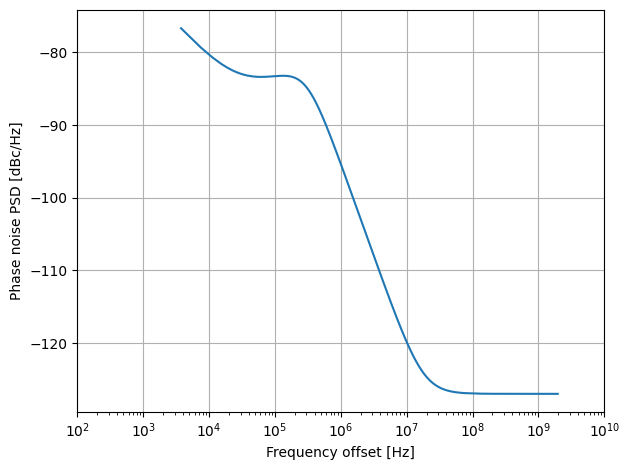

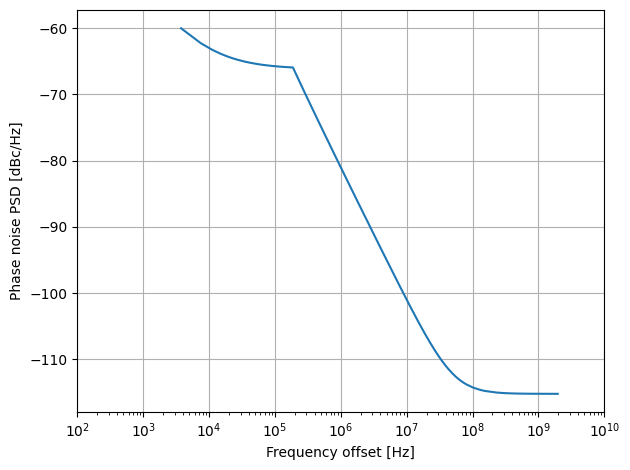

In [70]:
# for testing

import sionna as sn
import sionna.phy
tf.config.run_functions_eagerly(True)

total_samples = 4096
block_size = 512*64
sps = 4
batch_size = 1 #tf.cast(total_samples/block_size, tf.int32)
bw = 960e3*4096
fc = 220e9
ebno_db = 30
no = sn.phy.utils.ebnodb2no(ebno_db,
                        num_bits_per_symbol=4,
                        coderate=1.0)
print(10*np.log10(1/no))

filtlength = 32

constellation = sn.phy.mapping.Constellation("qam", num_bits_per_symbol=4) # 16QAM
mapper = sn.phy.mapping.Mapper(constellation=constellation)
demapper = sn.phy.mapping.Demapper("app", constellation=constellation, hard_out=False)
binary_source = sn.phy.mapping.BinarySource()
channel = sn.phy.channel.AWGN()
upsampler = sn.phy.signal.Upsampling(samples_per_symbol=sps)

tx_filter = sn.phy.signal.RootRaisedCosineFilter(beta=0.3,
                                                  samples_per_symbol=sps,
                                                  span_in_symbols=filtlength)
rx_filter = sn.phy.signal.RootRaisedCosineFilter(beta=0.3,
                                             samples_per_symbol=sps,
                                             span_in_symbols=filtlength)

downsampler = sn.phy.signal.Downsampling(samples_per_symbol=sps,
                                          offset=rx_filter.length - 1,
                                          num_symbols=block_size)
pn_tx = PhaseNoise(model_type='13', bandwidth=bw, fc=fc, n_samples=(block_size+filtlength)*sps)
pn_tx.plot_psd()
pn_rx = PhaseNoise(model_type='11', bandwidth=bw, fc=fc, n_samples=(block_size+filtlength)*sps)
pn_rx.plot_psd()
# ber = sn.utils.BitErrorRate()
rate_ = 0
pn_var_avg_tx = 0
pn_var_avg_rx = 0



In [71]:
print(pn_tx.samples)
print(pn_tx.n_samples)
print(pn_tx.fc)
print(pn_tx.bandwidth)
print(pn_tx.model_type)


524288
131200
220000000000.0
3932160000.0
13


In [72]:
for i in range(1):
    bits = binary_source([batch_size,block_size* 4])
    x = mapper(bits)
    x_ups = upsampler(x)
    x_filt = tx_filter(x_ups)
    print(x_filt.shape)
    x_pn, pn_var_tx, only_phase_n_tx = pn_tx(x_filt)
    y_chan = channel(x_pn, no)
    y_pn, pn_var_rx, _ = pn_rx(y_chan)
#     y_filt = rx_filter(y_pn)
#     y = downsampler(y_filt)
#     llr = demapper(y, no)
#     llr = tf.reshape(llr,[batch_size, block_size, 4])
#     bits = tf.reshape(bits, [batch_size, block_size, 4])
#     bce = tf.nn.sigmoid_cross_entropy_with_logits(labels=bits,
#                                                   logits=llr)
#     rate = bce / tf.math.log(2.)  # (blocks, RE per block, bit per RE)
#     hs = tf.cast(4, tf.float32)  # (1,)
#     rate = tf.reduce_mean(hs - tf.reduce_sum(rate, axis=2))  # (1,)
#     rate_ = rate+ rate_
#     #print('TX var :{} RX var:{}'.format(pn_var_tx, pn_var_rx))
#     pn_var_avg_tx = pn_var_tx+pn_var_avg_tx
#     pn_var_avg_rx = pn_var_rx + pn_var_avg_rx
#
#     #ber_sim = ber(bits, b_hat)
# print('RATE : {}'.format(rate_.numpy()/100.0))
# print('PN VAR TX: {}'.format(pn_var_avg_tx/100.0))
# print('PN VAR RX: {}'.format(pn_var_avg_rx / 100.0))
#
# # plt.figure()
# # plt.scatter(np.real(x_pn), np.imag(x_pn))
# # plt.scatter(np.real(constellation.points), np.imag(constellation.points))
# # plt.show()
#
# plt.figure()
# plt.scatter(np.real(y), np.imag(y))
# plt.scatter(np.real(constellation.points), np.imag(constellation.points))
# plt.show()

(1, 131200)


### Testing whether above class actually generates phase noise with desired PSD

In [73]:
bandwidth = 960e3*4096
samples = 131200
delta_f = bandwidth / tf.cast(samples, tf.float32)

In [74]:
hFPwr_list = []
pn_without_carrier = only_phase_n_tx - tf.complex(1.0, 0.0)

hF = tf.signal.fft(pn_without_carrier)/ (
    tf.cast(samples, tf.complex64) * tf.sqrt(tf.cast(delta_f, tf.complex64))
)

hFPwr = tf.math.real(hF * tf.math.conj(hF))  # linear PSD
hFPwr_list.append(hFPwr)

hFPwr_stack = tf.stack(hFPwr_list, axis=0)
hFPwr_avg = tf.signal.fftshift(tf.reduce_mean(hFPwr_stack, axis=0))
fvec_3 = np.arange(-samples//2, samples//2) / samples * bandwidth
hFPwr_dB = tf.squeeze(10.0 * tf.math.log(hFPwr_avg) / tf.math.log(10.0))

fvec = (bandwidth / 2) * np.linspace(0, 1, 1 + samples//2)
fvec = fvec[1:]
# PSD = 10 * np.log10(np.squeeze(lf))

In [78]:
fvec = (bandwidth / 2) * np.linspace(0, 1, pn_tx.samples)
PSD = 10 * np.log10(np.squeeze(pn_tx.lf.numpy()))

print(fvec.shape)
print(PSD.shape)


(524288,)
(524288,)


/tmp/ipykernel_21164/3083001778.py:2: RuntimeWarning: divide by zero encountered in log10
  PSD = 10 * np.log10(np.squeeze(pn_tx.lf.numpy()))


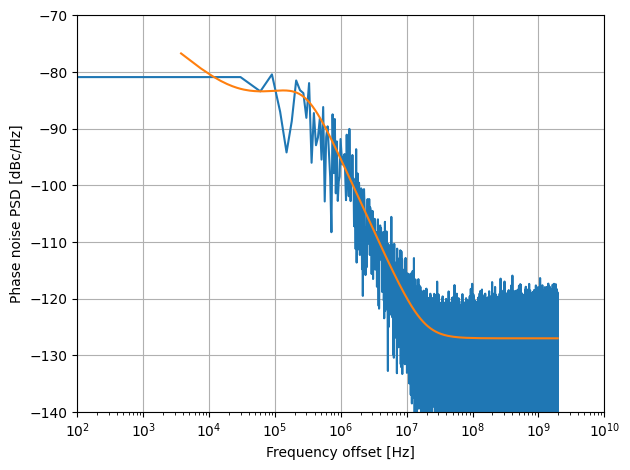

In [77]:
# Plot the PSD
fig = plt.figure()

ax1 = fig.add_subplot(111)

ax1.semilogx(fvec_3, hFPwr_dB)
ax1.semilogx(fvec, PSD)
# ax1.semilogx(fvec, PSD)
ax1.grid(True)
ax1.set_xlabel('Frequency offset [Hz]')
ax1.set_ylabel('Phase noise PSD [dBc/Hz]')
ax1.set_xlim([1e2, 1e10])
ax1.set_ylim([-140, -70])
plt.tight_layout()  # Adjust layout for subplots
#return ax
plt.show()

#### The desired and actual PSDs are approximately identical

### Trying out a separate method

In [3]:
%reset

In [80]:
import numpy as np
from sionna.phy.utils import complex_normal
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
sps = 4
block_size = 10
filtlength = 32
bandwidth = 960e3*4096
fc = 220e9
# n_samples = (block_size+filtlength)*sps
n_samples = 10**6

# samples = 2 * nextpow2(n_samples)

samples = n_samples
batch_size = 1

# fvec = (bandwidth / 2) * np.linspace(0, 1, samples)

fvec = (bandwidth / 2) * np.linspace(0, 1, 1 + samples//2)
fvec = fvec[1:]


In [4]:
fref = 20e9  # 70 GHz reference
psd0 = 10 ** ((-72.0) / 10)  # 39.49 dB
fz = [3e4, 1.75e7]
az = [1.4, 2.55]
fp = [1e1, 3e5]
ap = [1, 2.95]

lf = psd0 * np.ones([1, len(fvec)])  # PN PSD
for n in range(2):
    lf = lf * (1 + np.power((fvec / fz[n]), az[n])) / (1 + np.power((fvec / fp[n]), ap[n]))
# scale to carrier frq
lf = lf * np.square((fc / fref))

In [8]:
x = tf.cast(tf.ones([batch_size, n_samples]),tf.complex128)

In [ ]:
### For Troubleshooting

# # White complex Gaussian sequence
# src_t = complex_normal([tf.shape(x)[0], samples])
# src_f = tf.signal.fft(src_t)  # fft(src_t)
#
# # Apply PSD weights
# f_a = tf.complex(tf.sqrt(lf), tf.cast(0.0, tf.float64)) * tf.cast(src_f,tf.complex128)
#
# # Symmetric spectrum(PSD is also even symmetric) --> real time - domain process
# dc = tf.complex(tf.ones([batch_size, 1], dtype=tf.float64), tf.zeros([batch_size, 1], dtype=tf.float64))
#
# f_a = tf.concat([dc, f_a, tf.math.conj(tf.reverse(f_a, axis=[-1]))], axis=-1)
# theta_t = tf.signal.ifft(f_a)  # ifft(f_a)
#
# # Normalize to have correct variance
# theta_norm = theta_t * tf.cast(tf.sqrt(2 / (1 / bandwidth)), dtype=tf.complex128)
#
# # Take the required length from the middle (fftshift)
# required_samples_start_idx = tf.cast(samples / 2, dtype=tf.int32)
#
# pn_var = tf.math.reduce_variance(
#     theta_norm[:, required_samples_start_idx:required_samples_start_idx + n_samples])
#
# phase_noise = tf.math.exp(1j * theta_norm[:, required_samples_start_idx:required_samples_start_idx + n_samples])
# y = x * phase_noise
#
# phase_noise = tf.cast(phase_noise,tf.complex64)
# pn_without_carrier = phase_noise - tf.complex(1.0, 0.0)
#
# hF = tf.signal.fft(pn_without_carrier[:,:samples])/ tf.cast((tf.sqrt(n_samples*bandwidth)/2),tf.complex64)
# hFPwr = 10*tf.math.log(tf.squeeze(tf.math.real(hF * tf.math.conj(hF))))/2.3026 # /log(10)

In [5]:
hFPwr_list = []
n_iter = 40

delta_f = bandwidth / tf.cast(samples, tf.float32)

for itervalue in range(n_iter):
    tf.print('iter: ',itervalue)

    src_f = complex_normal([batch_size, samples])*(tf.sqrt(tf.cast(delta_f, tf.complex64)))*samples

    psd_squared = tf.concat([tf.math.conj(tf.reverse(lf, axis=[-1])),lf], axis=-1)

    f_a = tf.cast(src_f, tf.complex128) * tf.complex(tf.sqrt(psd_squared), tf.cast(0.0,tf.float64))

    theta_use = tf.signal.ifft(tf.signal.fftshift(f_a))

    phase_noise = tf.exp(1j*tf.cast(tf.sqrt(2.0),tf.complex128)* tf.complex(tf.math.real(theta_use),tf.cast(0.0,tf.float64)))
    phase_noise = tf.cast(phase_noise, tf.complex64)

    pn_without_carrier = phase_noise - tf.complex(1.0, 0.0)

    # --- PSD estimation ---

    hF = tf.signal.fft(pn_without_carrier)/ (
        tf.cast(n_samples, tf.complex64) * tf.sqrt(tf.cast(delta_f, tf.complex64))
    )

    hFPwr = tf.math.real(hF * tf.math.conj(hF))  # linear PSD
    hFPwr_list.append(hFPwr)

hFPwr_stack = tf.stack(hFPwr_list, axis=0)
hFPwr_avg = tf.signal.fftshift(tf.reduce_mean(hFPwr_stack, axis=0))
fvec_3 = np.arange(-samples//2, samples//2) / samples * bandwidth
hFPwr_dB = tf.squeeze(10.0 * tf.math.log(hFPwr_avg) / tf.math.log(10.0))

fvec = (bandwidth / 2) * np.linspace(0, 1, 1 + samples//2)
fvec = fvec[1:]
PSD = 10 * np.log10(np.squeeze(lf))


iter:  0


I0000 00:00:1768851194.447767   21164 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1060 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050, pci bus id: 0000:01:00.0, compute capability: 8.6


iter:  1
iter:  2
iter:  3
iter:  4
iter:  5
iter:  6
iter:  7
iter:  8
iter:  9
iter:  10
iter:  11
iter:  12
iter:  13
iter:  14
iter:  15
iter:  16
iter:  17
iter:  18
iter:  19
iter:  20
iter:  21
iter:  22
iter:  23
iter:  24
iter:  25
iter:  26
iter:  27
iter:  28
iter:  29
iter:  30
iter:  31
iter:  32
iter:  33
iter:  34
iter:  35
iter:  36
iter:  37
iter:  38
iter:  39


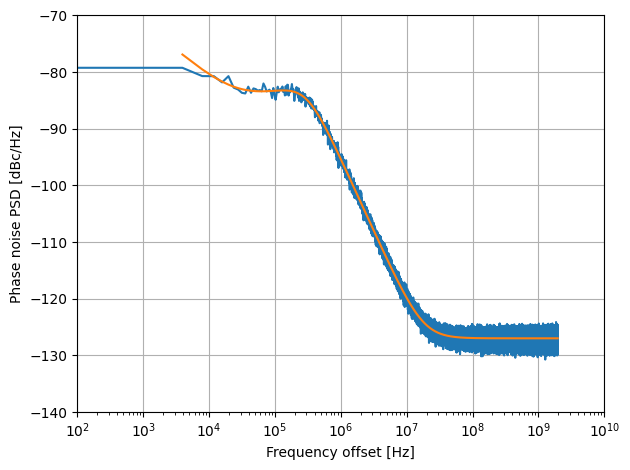

In [6]:

# Plot the PSD
fig = plt.figure()

# Main plot
ax1 = fig.add_subplot(111)
ax1.semilogx(fvec_3, hFPwr_dB)
ax1.semilogx(fvec, PSD)
ax1.grid(True)
ax1.set_xlabel('Frequency offset [Hz]')
ax1.set_ylabel('Phase noise PSD [dBc/Hz]')
ax1.set_xlim([1e2, 1e10])
ax1.set_ylim([-140, -70])
plt.tight_layout()  # Adjust layout for subplots
#return ax
plt.show()

### Testing correlation with autocorrelation

In [11]:
PSD_linear = 10**(PSD / 10)  # PSD in linear units


In [12]:
df = fvec[1] - fvec[0]  # frequency resolution


In [13]:
R_phi = np.fft.ifft(PSD_linear)
R_phi = np.fft.fftshift(np.real(R_phi))# center zero lag
# Scaling
R_phi = R_phi*bandwidth

In [14]:
N = len(PSD_linear)
tau = np.fft.fftshift(np.fft.fftfreq(N, d=df))


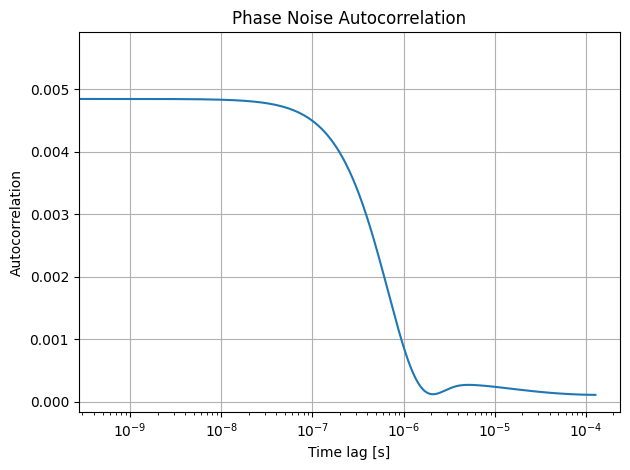

In [16]:
plt.figure()
plt.semilogx(tau, R_phi)
plt.grid(True)
plt.xlabel('Time lag [s]')
plt.ylabel('Autocorrelation')
plt.title('Phase Noise Autocorrelation')
plt.tight_layout()
plt.show()


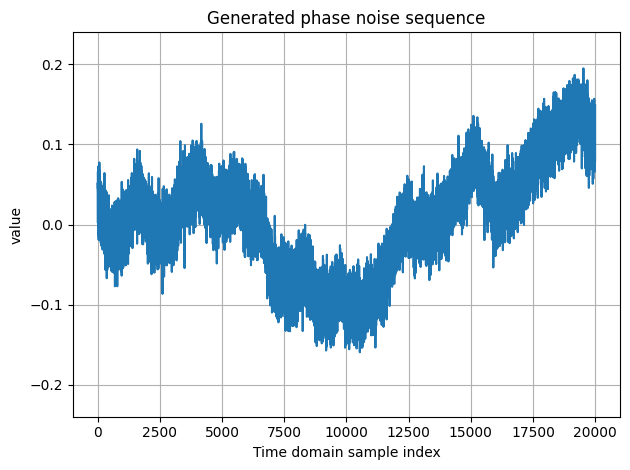

In [663]:
plt.figure()
indices_array = np.arange(20000)
plt.plot(indices_array, tf.math.real(theta_use[0,:20000]).numpy())
plt.grid(True)
plt.xlabel('Time domain sample index')
plt.ylabel('value')
plt.title('Generated phase noise sequence')
plt.ylim([-0.24, 0.24])
plt.tight_layout()
plt.show()

### Building new phase noise class using alternative method

In [90]:
class PhaseNoise_alt:
    def __init__(self, fc, bandwidth, samples,
                 n_iter=1,
                 psd_db=-72.0,
                 fref=20e9,
                 fz=[3e4, 1.75e7],
                 az=[1.4, 2.55],
                 fp=[1e1, 3e5],
                 ap=[1, 2.95]):

        self.fc = fc
        self.bandwidth = bandwidth
        self.samples = samples
        self.n_iter = n_iter
        fvec = (bandwidth / 2) * np.linspace(0, 1, 1 + samples//2)
        fvec = fvec[1:]

        # ----- Build PSD -----
        psd0 = 10 ** (psd_db / 10)

        lf = psd0 * np.ones([1, len(fvec)])

        for n in range(2):
            lf = lf * (1 + np.power((fvec / fz[n]), az[n])) / \
                      (1 + np.power((fvec / fp[n]), ap[n]))

        # scale to carrier frequency
        lf = lf * np.square((fc / fref))

        # Tensor version
        self.lf = tf.constant(lf, dtype=tf.float64)

        self.delta_f = bandwidth / tf.cast(samples, tf.float32)

    def _generate_pn(self, batch_size):
        # Complex Gaussian source in frequency domain
        src_f = (tf.complex(
                    tf.random.normal([batch_size, self.samples]),
                    tf.random.normal([batch_size, self.samples])
                 )
                 * tf.sqrt(tf.cast(self.delta_f, tf.complex64))
                 * self.samples)

        # Mirror PSD
        psd_squared = tf.concat([
            tf.math.conj(tf.reverse(self.lf, axis=[-1])),
            self.lf
        ], axis=-1)

        f_a = tf.cast(src_f, tf.complex128) * tf.complex(
                    tf.sqrt(psd_squared),
                    tf.cast(0.0, tf.float64)
              )

        theta_use = tf.signal.ifft(tf.signal.fftshift(f_a))

        phase_noise = tf.exp(
            1j * tf.cast(tf.sqrt(2.0), tf.complex128) *
            tf.complex(tf.math.real(theta_use),
                       tf.cast(0.0, tf.float64))
        )

        return tf.cast(phase_noise, tf.complex64)

    # ------------------------------------------------------------

    def __call__(self, symbols):
        """
        symbols : [batch_size, samples] complex64
        returns : phase-noise corrupted symbols
        """

        batch_size = tf.shape(symbols)[0]

        for itervalue in range(self.n_iter):
            tf.print("iter: ", itervalue)

            phase_noise = self._generate_pn(batch_size)

            # Remove carrier if needed (same as your code)
            # pn_without_carrier = phase_noise - tf.complex(1.0, 0.0)

            # Corrupt symbols

            print(phase_noise.shape)
            symbols = symbols * phase_noise

        return symbols, pn_without_carrier


In [106]:
constellation = sn.phy.mapping.Constellation("qam", num_bits_per_symbol=8) # 16QAM
mapper = sn.phy.mapping.Mapper(constellation=constellation)
bandwidth = 960e3*4096
fc = 220e9
batch_size = 1
block_size = 4096
samples = block_size
pn_test = PhaseNoise_alt(fc, bandwidth, samples)

In [107]:
bits = binary_source([batch_size,block_size* 8])
x = mapper(bits)


In [108]:
print(x.shape)

(1, 4096)


In [109]:
pn_out,_ = pn_test(x)

iter:  0
(1, 4096)


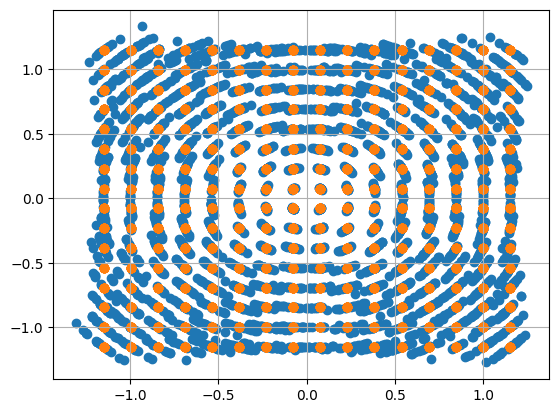

In [110]:
plt.figure()
plt.scatter(np.real(pn_out), np.imag(pn_out))
plt.scatter(np.real(x), np.imag(x))
plt.grid(True)
plt.show()